# Homework 2: Data from the Web

# Table of Contents

<p><div class="lev1"><a href="#0.-Retrieving-the-Data"><span class="toc-item-num">0.&nbsp;&nbsp;</span>Retrieving the Data</a></div>
<div class="lev1"><a href="#1.-Top-Universities-Data"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Top Universities Data</a></div>
<div class="lev1"><a href="#2.-Times-Higher-Education-Data"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Times Higher Education Data</a></div>
<div class="lev1"><a href="#3.-Merging-Two-Datasets"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Merging Two Datasets</a></div>
<div class="lev1"><a href="#4.-Exploratory-Data-Analysis"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Exploratory Data Analysis</a></div>
<div class="lev1"><a href="#5.-Best-University-(aside-from-EPFL-:))"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Best University (aside from EPFL :))</a></div>

**NB:**
- To accelerate the request part, <a href="https://pypi.python.org/pypi/requests-futures">`FuturesSession`</a>  was used: `pip install requests-futures`.
- To be able to compare the structure of the scraped data with Chrome Inspector's output, `html5lib` was used: `pip install html5lib` (if you still don't have it).

In [2]:
import requests
import pandas as pd
import numpy as np
from IPython.display import display
from bs4 import BeautifulSoup
import json
from requests_futures.sessions import FuturesSession
import datetime
from Data.data_country import *
from Visualization.visualization import *
import seaborn as sns

# 0. Retrieving the Data

In [3]:
TOP_UNI_URL = "https://www.topuniversities.com"

In [4]:
URL_init = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'

We start by retrieving and parsing the HTML page:

In [5]:
r_init = requests.get(URL_init)
soup = BeautifulSoup(r_init.text, 'html5lib') # This parser should be the closest one to Chrome Inspector.

Upon inspection with google chrome we see that the data is contained in a div whose class is "panel-panel-inner". Therefore we retrieve it using BeautifulSoup.

In [7]:
inner_panel = soup.find('div', {'class': 'panel-panel-inner'})
print(inner_panel.prettify()[:200] + '\n\n...\n\n' + inner_panel.prettify()[-200:])

<div class="panel-panel-inner">
 <div class="panel-pane pane-block pane-block-7 pane-node-field-article-date">
  <div class="pane-content">
   <div class="pane-qs-wur-app">
    <a class="app-store-bad

...

v>
     <script type="text/javascript">
      googletag.cmd.push(function() {
      googletag.display("dfp-ad-site_wide_tablet_2");
    });
     </script>
    </div>
   </div>
  </div>
 </div>
</div>



Looks like what we've got in Chrome Inspector!

<img src="./pics/inner_panel.png" alt="inner_panel" style="width: 600px;" />

However, if we take a closer look at where might be the data we are looking for ...

<img src="./pics/thead-tbody.png" alt="thead" style="width: 600px;"/>

In [14]:
inner_panel.find('thead') is None

False

In [15]:
inner_panel.find('tbody') is None

True

... whoops! `<thead>` is there, `<tbody>`, however, is not. Must be side-loaded via JavaScript.

Let's take a look at what kind of XHRs are there ...

<img src="./pics/xhr.png" alt="tbody" style="width: 600px;"/>

Note the `.txt` file of the largest size and loading time, let's see what's inside ...

In [8]:
URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'
data = requests.get(URL).json()
print(json.dumps(data, sort_keys=True, indent=4)[:400] + \
      '\n\n...\n\n' + json.dumps(data, sort_keys=True, indent=4)[-400:])

{
    "data": [
        {
            "cc": "US",
            "core_id": "410",
            "country": "United States",
            "guide": "<a href=\"/where-to-study/north-america/united-states/guide\" class=\"guide-link\" target=\"_blank\">United States</a>",
            "logo": "<img src=\"https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0

...

versity-of-technology_592560cf2aeae70239af5039_small.jpg\" alt=\"Wroclaw University of Technology Logo\">",
            "nid": "296503",
            "rank_display": "801-1000",
            "region": "Europe",
            "score": "",
            "stars": null,
            "title": "Wroclaw University of Technology",
            "url": "/universities/wroclaw-university-technology"
        }
    ]
}


That's exactly the data we were looking for, no need to web-scrape anymore, yay!

# 1. Top Universities Data

Let's use the json data extracted above ...

In [17]:
data = data['data']

... and add some helper functions:
- *get_link* Adds the prefix `TOP_UNI_URL` to a relative URL to make it absolute.
- *format_rank* Formats rankings to remove "="s from the string and cast it in `int`.

In [18]:
def get_link(x):
    return TOP_UNI_URL + x

def format_rank(x):
    return int(x.replace('=', ''))

Now we want to drop the features that we don't need for sure.
We need these:
- *name* (**title**)
- *rank* (**rank_display**)
- *country* (**country**) and *region* (**region**)
- *number of faculty members (international and total)* and *number of students (international and total)* (might need **url** to extract these).

In [20]:
df = pd.DataFrame(data)
df = df.head(200)

df = df[['title', 'region', 'rank_display', 'country', 'url']]
df = df.rename(columns={'title': 'name', 'country': 'location', 'rank_display':'overall_rank'})
df['overall_rank'] = df['overall_rank'].apply(lambda x: format_rank(x))
df['url'] = df['url'].apply(lambda x: get_link(x))
display(df.head())

,name,region,overall_rank,location,url
0,Massachusetts Institute of Technology (MIT),North America,1,United States,https://www.topuniversities.com/universities/m...
1,Stanford University,North America,2,United States,https://www.topuniversities.com/universities/s...
2,Harvard University,North America,3,United States,https://www.topuniversities.com/universities/h...
3,California Institute of Technology (Caltech),North America,4,United States,https://www.topuniversities.com/universities/c...
4,University of Cambridge,Europe,5,United Kingdom,https://www.topuniversities.com/universities/u...


Now let's for each uni follow its link in and scrape the numbers that we need:
- *number of faculty members (international and total)*
- *number of students (international and total)*

The function **`find_number`** below extracts the numbers of interest. It shrinks the current soup at each iteration until it reaches the last `div` that contains the number. If during at some point it finds that the current soup is `None` (there's no such number in the json) it returns 0.

In [21]:
def find_number(soup, list_dict_div):
    current_soup = soup
    for dict_div in list_dict_div:
        current_soup = current_soup.find("div", dict_div)
        if(current_soup is None):
            return 0
    return int(current_soup.text.replace(",", ""))

The function **`get_extra_data`** below returns all 4 numbers *(faculty int/tot, students int/tot)* for a given response `x` using **`find_number`**.

In [22]:
def get_extra_data(x):
    soup = BeautifulSoup(x.text, 'html.parser')

    total_faculty_int = find_number(soup, [{ "class": "faculty-main wrapper col-md-4" }, { "class": "total faculty"}, { "class": "number"}])
    inter_faculty_int = find_number(soup, [{ "class": "faculty-main wrapper col-md-4" }, { "class": "inter faculty"}, { "class": "number"}])
    number_students_int = find_number(soup, [{"class": "students-main wrapper col-md-4"}, { "class": "number"}])
    international_students_int = find_number(soup, [{"class": "int-students-main wrapper col-md-4"}, { "class": "number"}])

    return pd.DataFrame(data = [[total_faculty_int,inter_faculty_int,number_students_int,international_students_int]], columns = ['total faculty','international faculty','number of students','international students'])

To save some time, let's use <a href="https://pypi.python.org/pypi/requests-futures">`FuturesSession`</a> library. It allows us to asynchronously make HTTP requests.

In [23]:
df_temp = df[['url']]

urls = df_temp.values.tolist()
urls = [item for sublist in urls for item in sublist]

session = FuturesSession(max_workers=10)
futures = []
results =[]

First, we use *futures* to send multiple requests without waiting for the response of the last request to send the next one.

In [24]:
for url in urls:
    future = session.get(url)
    futures.append((url, future))

Second, we collect all the responses of the sent requests.

In [25]:
for url, r in futures:
    results.append((url, r.result()))

Finally, we extract the information that we want from those requests as a `DataFrame`. We retrieve our 4 numbers of interest and URLs which help us to ease the merge with the original `DataFrame` thereafter.

In [26]:
list_dataframe = []

for url, result in results:
    list_dataframe.append(pd.concat([get_extra_data(result), pd.DataFrame(data=[url], columns=['url'])], axis=1))

Let's concatenate each of the resulting `DataFrame`s into a larger one.

In [27]:
df_temp = pd.concat(list_dataframe)
display(df_temp.head())

,total faculty,international faculty,number of students,international students,url
0,2982,1679,11067,3717,https://www.topuniversities.com/universities/m...
0,4285,2042,15878,3611,https://www.topuniversities.com/universities/s...
0,4350,1311,22429,5266,https://www.topuniversities.com/universities/h...
0,953,350,2255,647,https://www.topuniversities.com/universities/c...
0,5490,2278,18770,6699,https://www.topuniversities.com/universities/u...


Now we just merge *on the URL* the fresh `DataFrame` and the original one.

In [28]:
df = df.merge(df_temp, left_on='url', right_on='url', how='outer')
df = df.drop('url', 1)

In [29]:
display(df.head())

,name,region,overall_rank,location,total faculty,international faculty,number of students,international students
0,Massachusetts Institute of Technology (MIT),North America,1,United States,2982,1679,11067,3717
1,Stanford University,North America,2,United States,4285,2042,15878,3611
2,Harvard University,North America,3,United States,4350,1311,22429,5266
3,California Institute of Technology (Caltech),North America,4,United States,953,350,2255,647
4,University of Cambridge,Europe,5,United Kingdom,5490,2278,18770,6699


The function **`get_ratio`** below returns us two new `DataFrame`s that contain respectively each in a new column:
- the ratio between faculty members and students,
- the ratio of international students.

In [30]:
def get_ratio(df):
    df_ratio = df.copy()
    
    df_ratio['ratio'] = df_ratio['total faculty'] / df_ratio['number of students']
    df_ratio = df_ratio.sort_values('ratio', ascending=False)
    r1 = df_ratio.copy()
    
    df_ratio['ratio'] = df_ratio['international students'] / df_ratio['number of students']
    df_ratio = df_ratio.sort_values('ratio', ascending=False)
    r2 = df_ratio.copy()
    
    return r1, r2

## Plotting

### a, b) Computing ratios 

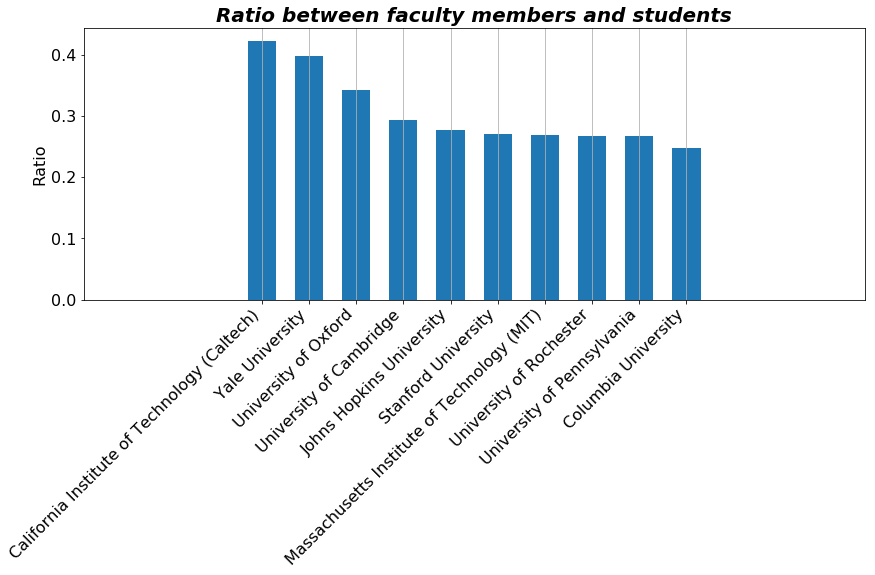

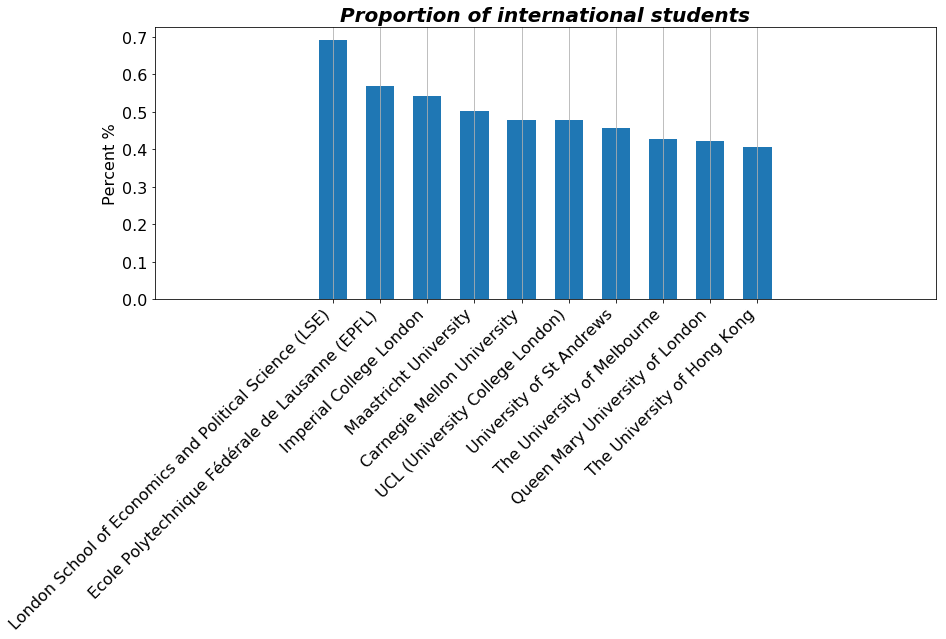

In [43]:
r1, r2 = get_ratio(df)
pretty_bar(r1['ratio'][:10], r1['name'][:10], "Ratio between faculty members and students", "", "Ratio", figwidth=14, rot='vertical', plot_margin=3)
pretty_bar(r2['ratio'][:10], r2['name'][:10], "Proportion of international students", "", "Percent %", figwidth=14, rot='vertical', plot_margin=3)

### c) Grouping by country

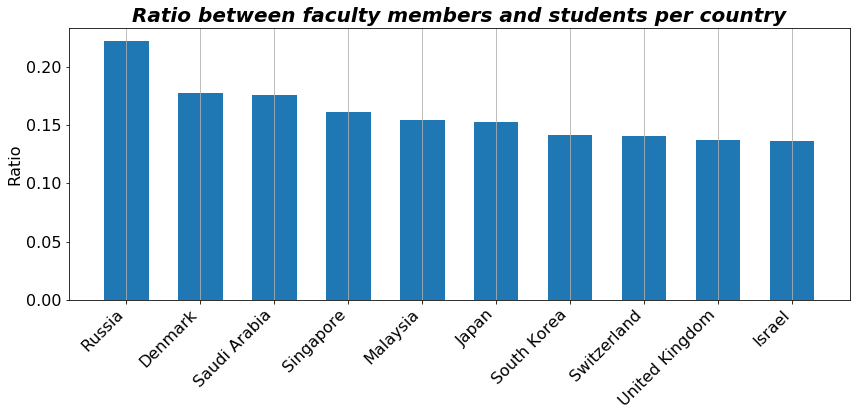

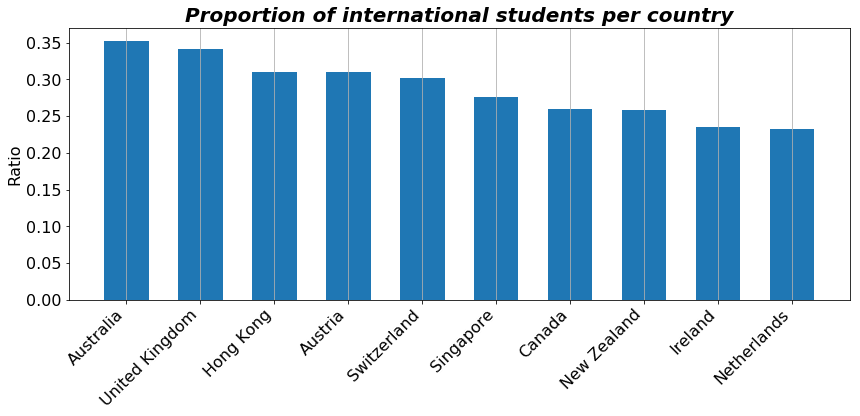

In [44]:
r1, r2 = get_ratio(df.groupby('location').sum().reset_index())
pretty_bar(r1['ratio'][:10], r1['location'][:10], "Ratio between faculty members and students per country", "", "Ratio", figwidth=14, rot='vertical')
pretty_bar(r2['ratio'][:10], r2['location'][:10], "Proportion of international students per country", "", "Ratio", figwidth=14, rot='vertical')

### d) Grouping by region

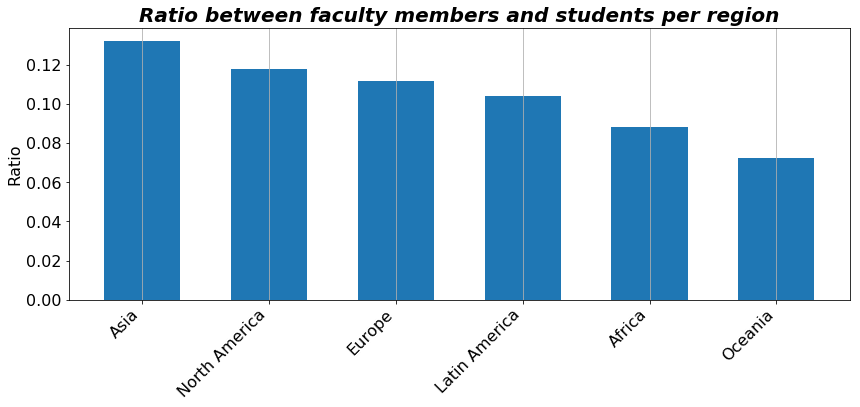

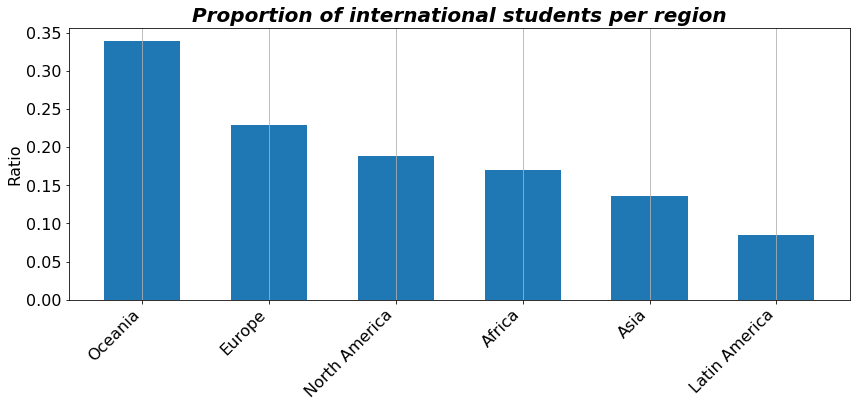

In [45]:
r1, r2 = get_ratio(df.groupby('region').sum().reset_index())
pretty_bar(r1['ratio'][:10], r1['region'][:10], "Ratio between faculty members and students per region", "", "Ratio", figwidth=14, rot='vertical')
pretty_bar(r2['ratio'][:10], r2['region'][:10], "Proportion of international students per region", "", "Ratio", figwidth=14, rot='vertical')

# 2. Times Higher Education Data

As in the first question, we get the URL that provides us the JSON data.

In [41]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
json = r.json()['data']

Again, let's drop the features that we don't need. These we do need:
- *name* (**name**)
- *aliases* (**aliases**)
- *rank* (**rank**)
- *country* (**location**)
- *number of students* (**stats_number_students**)
- *percentage of international students* (**stats_pc_intl_students**)
- *ratio of students per staff* (**stats_student_staff_ratio**)

In [42]:
df_2 = pd.DataFrame(json)
df_2 = df_2[['aliases', 'name', 'location', 'rank', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio']]
df_2 = df_2.head(200)
display(df_2.head())

,aliases,name,location,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,University of Oxford,University of Oxford,United Kingdom,1,"20,409",38%,11.2
1,University of Cambridge,University of Cambridge,United Kingdom,2,"18,389",35%,10.9
2,California Institute of Technology caltech,California Institute of Technology,United States,=3,"2,209",27%,6.5
3,Stanford University,Stanford University,United States,=3,"15,845",22%,7.5
4,Massachusetts Institute of Technology,Massachusetts Institute of Technology,United States,5,"11,177",34%,8.7


Clearly, we need to clean up the data.

To do this, we define some helpers:
- **`format_percentage_students`** removes the "%" and divides by 100 to get the proportion.
- **`format_number_students`** removes the comma and casts to `int` the number of students.
- **`get_continent`** returns the continent of the given country using the data from the library `incf.countryutils`.

In [46]:
def format_percentage_students(x):
    return int(x.replace('%', '')) / 100

def format_number_students(x):
    return int(x.replace(',', ''))

def get_continent(country):
    return ctca2_to_ctn.get(ccn_to_ctca2.get(cn_to_ccn.get(country)))

Let's now apply these. Based on the data we've got, we then easily calculate:
- the number of faculty members (total),
- number of students (international and total).

In [47]:
df_2['stats_pc_intl_students'] = df_2['stats_pc_intl_students'].apply(lambda x: format_percentage_students(x))
df_2['rank'] = df_2['rank'].apply(lambda x: format_rank(x))
df_2['stats_number_students'] = df_2['stats_number_students'].apply(lambda x: format_number_students(x))
df_2['stats_student_staff_ratio'] = df_2['stats_student_staff_ratio'].apply(pd.to_numeric)


df_2['international students'] = df_2['stats_number_students'] * df_2['stats_pc_intl_students']
df_2['total faculty'] = (df_2['stats_number_students'] / df_2['stats_student_staff_ratio']).astype(int)
df_2 = df_2.drop(['stats_pc_intl_students', 'stats_student_staff_ratio'], 1)
df_2['region'] = df_2['location'].apply(lambda x: get_continent(x))

df_2 = df_2.rename(columns={'stats_number_students': 'number of students'})

As in Question 1, let's use **`get_ratio`** to get the ratios of interest and plot them.

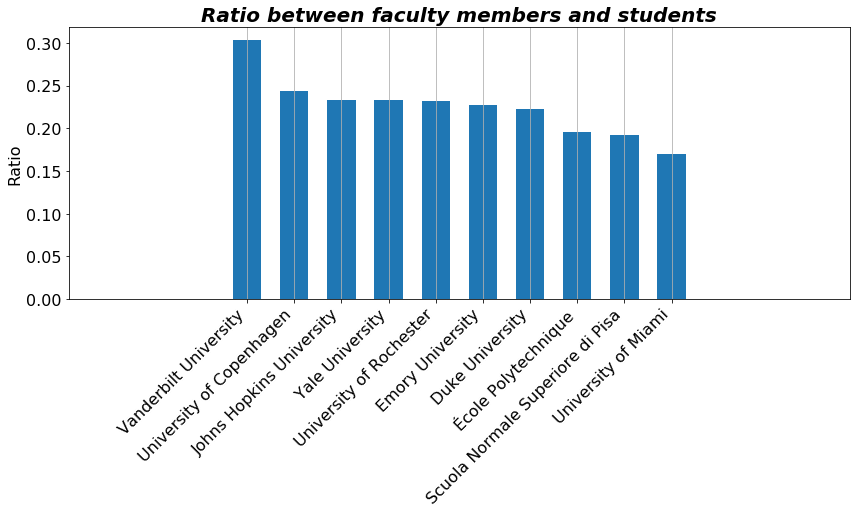

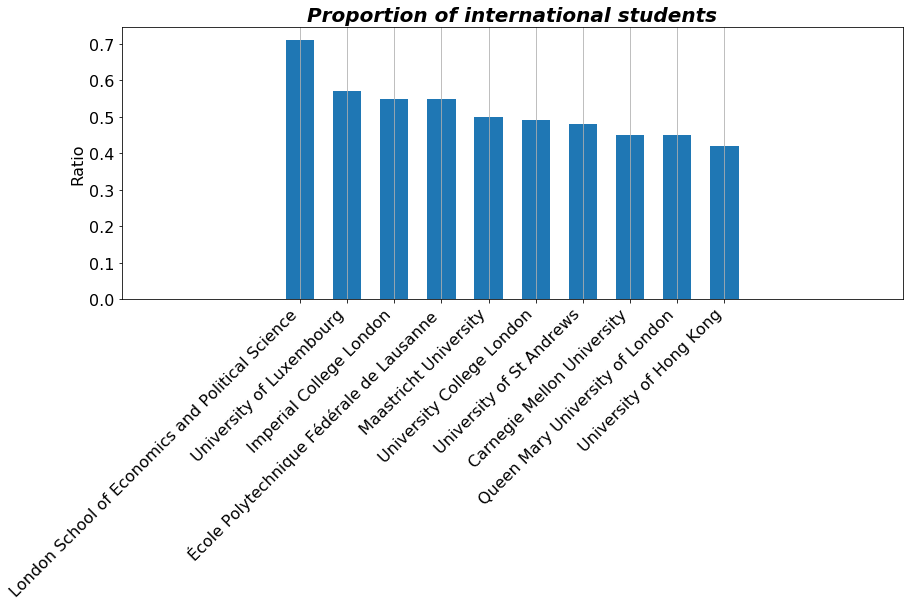

In [48]:
r1, r2 = get_ratio(df_2)
pretty_bar(r1['ratio'][:10], r1['name'][:10], "Ratio between faculty members and students", "", "Ratio", figwidth=14, rot='vertical', plot_margin=3)
pretty_bar(r2['ratio'][:10], r2['name'][:10], "Proportion of international students", "", "Ratio", figwidth=14, rot='vertical', plot_margin=3)

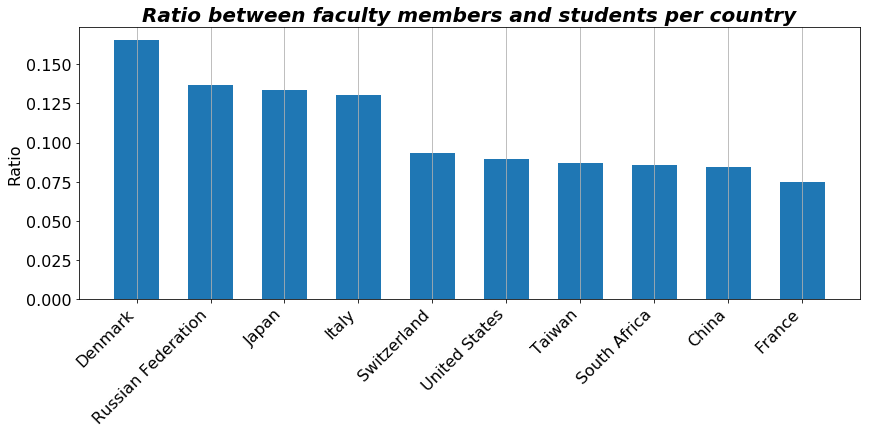

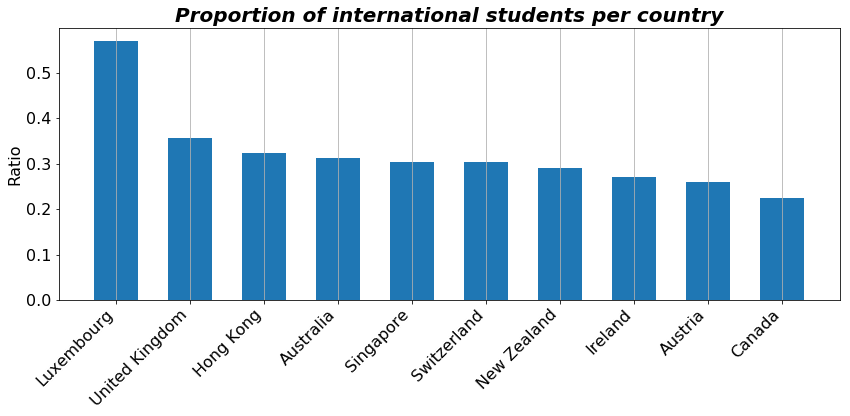

In [49]:
r1, r2 = get_ratio(df_2.groupby('location').sum().reset_index())
pretty_bar(r1['ratio'][:10], r1['location'][:10], "Ratio between faculty members and students per country", "", "Ratio", figwidth=14, rot='vertical')
pretty_bar(r2['ratio'][:10], r2['location'][:10], "Proportion of international students per country", "", "Ratio", figwidth=14, rot='vertical')

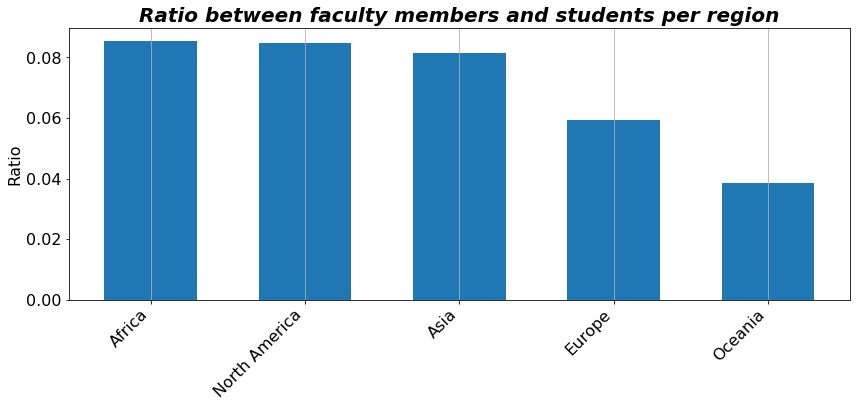

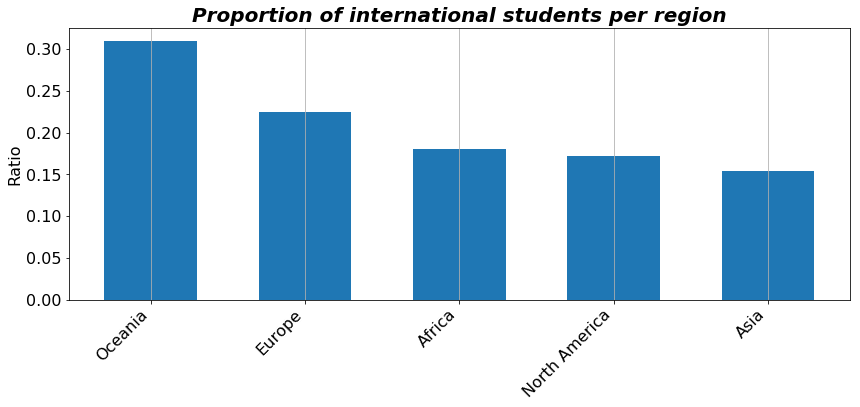

In [50]:
r1, r2 = get_ratio(df_2.groupby('region').sum().reset_index())
pretty_bar(r1['ratio'][:10], r1['region'][:10], "Ratio between faculty members and students per region", "", "Ratio", figwidth=14, rot='vertical')
pretty_bar(r2['ratio'][:10], r2['region'][:10], "Proportion of international students per region", "", "Ratio", figwidth=14, rot='vertical')

# 3. Merging Two Datasets
## Overview

To merge the two datasets, we use the following algorithm:

1. Perform a <a href="https://community.alteryx.com/t5/Alteryx-Knowledge-Base/Cartesian-Join-Cartesian-Product/ta-p/39009">*Cartesian join (product)*</a> of the two datasets,
2. Keep only the entries which universities are located in the same country,
3. Transform the universities' names into keyword sets,
4. For each university, keep only the entry which keywords-intersection-count is the highest,
5. Remove the matches which keyword-intersection-counts are lower than 2.

This produces a `DataFrame` of 154 common universities.

## Detailed Procedure

Let's create new columns containing a cleaned up version of the universities' names:

In [51]:
top_universities_ranking = df.copy()
times_higher_ranking = df_2.copy()

top_universities_ranking.rename(columns={'overall_rank': 'rank'}, inplace=True)
times_higher_ranking.drop('aliases', axis=1, inplace=True)

cleanup_regex = '[^a-zA-Z ]|the |of |at '
top_universities_ranking['split_name'] = top_universities_ranking['name'].str.lower().str.replace(cleanup_regex, '').str.split()
times_higher_ranking['split_name'] = times_higher_ranking['name'].str.lower().str.replace(cleanup_regex, '').str.split()

top_universities_ranking['split_name'] = top_universities_ranking['split_name'].apply(set)
times_higher_ranking['split_name'] = times_higher_ranking['split_name'].apply(set)


top_universities_ranking.columns = pd.MultiIndex.from_product([['topuniversities.com'], top_universities_ranking.columns])
times_higher_ranking.columns = pd.MultiIndex.from_product([['timeshighereducation.com'], times_higher_ranking.columns])

Now we add a dummy key to each `DataFrame` to make the `merge` operation a Cartesian join:

In [53]:
# Add a dummy key to perform Cartesian join
top_universities_ranking['topuniversities.com', 'dummy key'] = 1
times_higher_ranking['timeshighereducation.com', 'dummy key'] = 1

# Perform Cartesian join
top_merged = pd.merge(top_universities_ranking, times_higher_ranking,
                      left_on=top_universities_ranking['topuniversities.com','dummy key'],
                     right_on=times_higher_ranking['timeshighereducation.com', 'dummy key'])

Let's remove the entries that obviously don't match:

In [54]:
# Remove rows with different locations as they obviously don't match
top_merged['same country'] = top_merged['topuniversities.com', 'location'] == top_merged['timeshighereducation.com', 'location']
top_merged = top_merged[top_merged['same country'] == True]

Now it's time to create a new column containing the keyword sets of both `DataFrame`s, zipped in a tuple. This is useful for counting easily the number of common elements in both sets.

In [55]:
# Prepare set intersection by zipping names together
top_merged['zipped'] = list(zip(
    top_merged['topuniversities.com', 'split_name'], 
    top_merged['timeshighereducation.com', 'split_name']))

# Count the number of words in the intersection of names sets
top_merged['intersection count'] = top_merged['zipped'].apply(lambda tup: len(set.intersection(tup[0], tup[1])))

For each university, we extract the entry with the highest amount of common keywords. Additionally, we remove the entries with keyword-counts lower than 2 as they most certainly represent garbage. This can happen if a given university is not represented in both rankings.

In [56]:
# Keep only the rows with the highest number of common keywords
top_merged = top_merged.sort_values('intersection count', ascending=False)
top_merged.drop_duplicates(('topuniversities.com', 'name'), inplace=True)
top_merged = top_merged[top_merged['intersection count'] >= 2]

Finally, we perform some housekeeping and sort the entries back by the ranking from *topuniversities.com*.

In [57]:
# Remove unnecessary columns
top_merged.drop(['split_name', 'dummy key'], level=1, axis=1, inplace=True)
top_merged.drop(['zipped', 'intersection count', 'same country'], level=0, axis=1, inplace=True)

# Remove outlier found by luck
top_merged.drop(8581, axis=0, inplace=True)
top_merged.drop(35060, axis=0, inplace=True)

# Convert to numeric values instead of strings
top_merged = top_merged.apply(pd.to_numeric, errors='ignore')

# Sort back the value by topuniversities.com score
top_merged = top_merged.sort_values(('topuniversities.com', 'rank'))
top_merged2 = top_merged.copy()
display(top_merged.head())

topuniversities.com                      \
                                             name         region rank   
4     Massachusetts Institute of Technology (MIT)  North America    1   
203                           Stanford University  North America    2   
405                            Harvard University  North America    3   
602  California Institute of Technology (Caltech)  North America    4   
801                       University of Cambridge         Europe    5   

                                                                            \
           location total faculty international faculty number of students   
4     United States          2982                  1679              11067   
203   United States          4285                  2042              15878   
405   United States          4350                  1311              22429   
602   United States           953                   350               2255   
801  United Kingdom          5490                  2278              18770   

                                         timeshighereducation.com  \
    international students                                   name   
4                     3717  Massachusetts Institute of Technology   
203                   3611                    Stanford University   
405                   5266                     Harvard University   
602                    647     California Institute of Technology   
801                   6699                University of Cambridge   

                                                                    \
           location rank number of students international students   
4     United States    5              11177                3800.18   
203   United States    3              15845                3485.90   
405   United States    6              20326                5284.76   
602   United States    3               2209                 596.43   
801  United Kingdom    2              18389                6436.15   

                                  
    total faculty         region  
4            1284  North America  
203          2112  North America  
405          2283  North America  
602           339  North America  
801          1687         Europe

# 4. Exploratory Data Analysis

In [58]:
top_merged.describe()

topuniversities.com                                      \
                     rank total faculty international faculty   
count          152.000000    152.000000            152.000000   
mean            87.967105   2907.125000            888.881579   
std             56.125854   1591.516214            683.621230   
min              1.000000      0.000000              0.000000   
25%             38.000000   1732.000000            434.500000   
50%             84.000000   2736.500000            673.000000   
75%            135.000000   3679.750000           1155.750000   
max            200.000000   9581.000000           3905.000000   

                                                timeshighereducation.com  \
      number of students international students                     rank   
count         152.000000             152.000000               152.000000   
mean        24917.348684            5525.118421                88.263158   
std         13265.711446            3755.704676                54.618331   
min             0.000000               0.000000                 1.000000   
25%         15713.000000            2954.250000                43.750000   
50%         23777.500000            4717.000000                83.000000   
75%         32162.000000            7445.750000               132.250000   
max         72207.000000           21910.000000               198.000000   

                                                               
      number of students international students total faculty  
count         152.000000             152.000000    152.000000  
mean        25148.717105            5335.584671   1833.059211  
std         13097.432419            3252.450091   1126.196313  
min           515.000000              36.050000     99.000000  
25%         15758.250000            2997.045000    959.750000  
50%         24055.000000            4661.760000   1664.500000  
75%         32933.250000            7159.665000   2392.000000  
max         69427.000000           16846.400000   7413.000000

## Correlations

Let's see if some variables are correlated.

In [68]:
corr_m = top_merged.corr()
corr_m.sort_index(inplace=True)
corr_m.sort_index(axis=1, inplace=True)
idx = pd.IndexSlice
corr_m.loc[idx['timeshighereducation.com', : ], idx['topuniversities.com', ['international faculty', 'international students', 'number of students', 'total faculty']]] = '-'
corr_m.loc[idx['timeshighereducation.com', ['international faculty', 'international students', 'number of students', 'total faculty'] ], idx['topuniversities.com', : ]] = '-'
corr_m.loc[idx['topuniversities.com', : ], idx['timeshighereducation.com', ['international faculty', 'international students', 'number of students', 'total faculty']]] = '-'
corr_m.loc[idx['topuniversities.com', ['international faculty', 'international students', 'number of students', 'total faculty'] ], idx['timeshighereducation.com', : ]] = '-'
display(corr_m)

timeshighereducation.com  \
                                                  international students   
timeshighereducation.com international students                        1   
                         number of students                     0.552005   
                         rank                                  -0.288288   
                         total faculty                          0.197941   
topuniversities.com      international faculty                         -   
                         international students                        -   
                         number of students                            -   
                         rank                                          -   
                         total faculty                                 -   

                                                                              \
                                                number of students      rank   
timeshighereducation.com international students           0.552005 -0.288288   
                         number of students                      1 -0.128019   
                         rank                            -0.128019         1   
                         total faculty                    0.566546 -0.225869   
topuniversities.com      international faculty                   -         -   
                         international students                  -         -   
                         number of students                      -         -   
                         rank                                    -  0.713439   
                         total faculty                           -         -   

                                                               \
                                                total faculty   
timeshighereducation.com international students      0.197941   
                         number of students          0.566546   
                         rank                       -0.225869   
                         total faculty                      1   
topuniversities.com      international faculty              -   
                         international students             -   
                         number of students                 -   
                         rank                               -   
                         total faculty                      -   

                                                  topuniversities.com  \
                                                international faculty   
timeshighereducation.com international students                     -   
                         number of students                         -   
                         rank                                       -   
                         total faculty                              -   
topuniversities.com      international faculty                      1   
                         international students              0.586928   
                         number of students                  0.314988   
                         rank                               -0.517654   
                         total faculty                        0.67846   

                                                                        \
                                                international students   
timeshighereducation.com international students                      -   
                         number of students                          -   
                         rank                                        -   
                         total faculty                               -   
topuniversities.com      international faculty                0.586928   
                         international students                      1   
                         number of students                   0.636341   
                         rank                                -0.265439   
                         total faculty                        0.436635

### International Faculty Members vs Rank
In these results we observe that the ranks from both websites are positively correlated, which was to be expected. 

However, it's worth noticing that in the data from *topuniversities.com* there is a moderate **negative correlation** between *the number of international faculty members* and *the rank of the university*. That is, the more international faculty members a university has, the higher its rank is. It is quite plausible that a top ranking univerity attracts people from all over the world.

The following plot displays the bivariate distribution of these two variables:

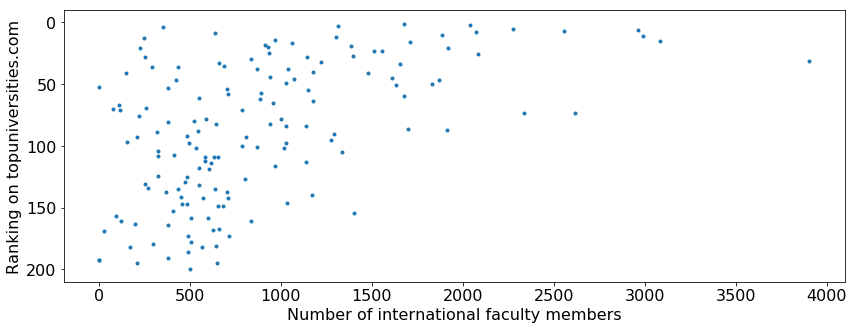

In [69]:
plt.scatter(top_merged[('topuniversities.com', 'international faculty')], top_merged[('topuniversities.com', 'rank')], marker='.'); plt.ylim((-10,210)); plt.xlabel("Number of international faculty members", fontsize=16);plt.ylabel("Ranking on topuniversities.com",fontsize=16); plt.gca().invert_yaxis();plt.show();

To a lesser extent, the more international students or the more faculty members a university has, the higher it tends to score on the leaderboards. Still, there's no clear correlation between the number of domestic students and the university ranking:

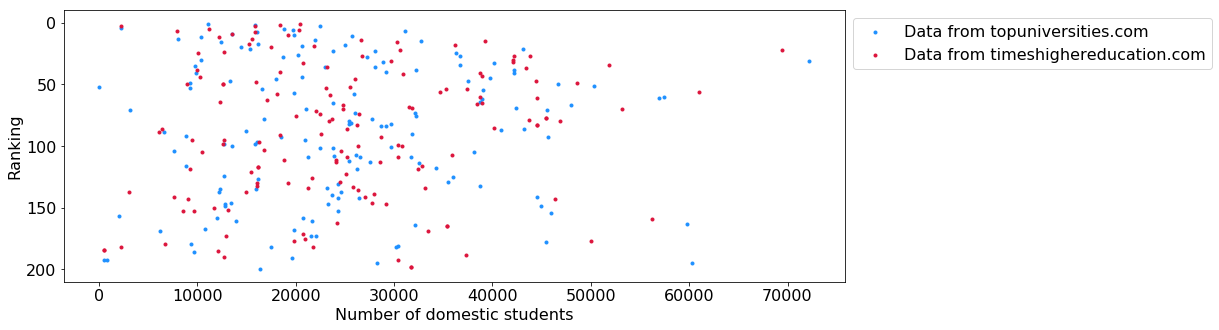

In [70]:
plt.scatter(top_merged[('topuniversities.com', 'number of students')], top_merged[('topuniversities.com', 'rank')], c='dodgerblue', marker='.');plt.scatter(top_merged[('timeshighereducation.com', 'number of students')], top_merged[('timeshighereducation.com', 'rank')], c='crimson', marker='.');plt.legend(['Data from topuniversities.com', 'Data from timeshighereducation.com'], bbox_to_anchor=(1,1), fontsize=16);plt.xlabel("Number of domestic students", fontsize=16);plt.ylabel("Ranking", fontsize=16);plt.gca().invert_yaxis();plt.show()

### International members

In [64]:
print("Correlation between number of international faculty members and both international students and total students:")
print(corr_m.loc[idx['topuniversities.com', 'international faculty'], idx['topuniversities.com', ['international students', 'number of students']]].values)

Correlation between number of international faculty members and both international students and total students:
[0.5869284560046949 0.31498785259319284]


#### Number of students
We see that in general, the higher the number of international students registered in a university, the more international faculty members are present.

Indeed, the corelation between international students and international faculty members is 0.588137 while the correlation between the total number of students and the international faculty members is 0.323739. This might suggest that when a university has a high international visibility, it attracts both foreign faculty members and students.

## Differences in rankings

count    152.000000
mean       0.296053
std       41.942540
min     -107.000000
25%      -23.250000
50%        0.000000
75%       25.000000
max      126.000000
Name: rank difference, dtype: float64


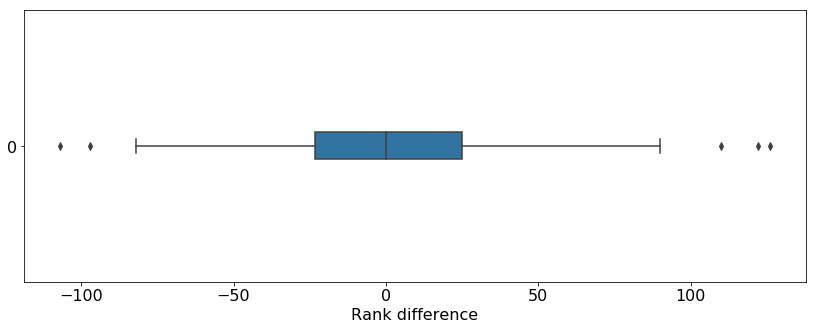

In [65]:
rdiff = top_merged.copy()
rdiff['rank difference'] = rdiff[('timeshighereducation.com', 'rank')] - rdiff[('topuniversities.com', 'rank')]
print(rdiff['rank difference'].describe())
sns.boxplot(data=rdiff['rank difference'].values, orient='h', width=0.1)
plt.xlabel("Rank difference", fontsize=16)
plt.show()

It is interesting that on average (over the 152 universities found in both rankings) the two rankings agree with each other (the mean and median are close to zero) while the standard deviation is very large!

We can display the universities for which Times Higher Education gave the highest ranking (negative difference) as well as the lowest ranking with respect to *topuniversities.com* (positive difference).

In [66]:
display(rdiff[rdiff['rank difference']==-107])
display(rdiff[rdiff['rank difference']==126])

topuniversities.com                                     \
                          name         region rank       location   
32455  University of Minnesota  North America  163  United States   

                                                              \
      total faculty international faculty number of students   
32455          4919                   195              59742   

                             timeshighereducation.com                      \
      international students                     name       location rank   
32455                   6542  University of Minnesota  United States   56   

                                                                              \
      number of students international students total faculty         region   
32455              60949                6704.39          3502  North America   

      rank difference  
                       
32455            -107

topuniversities.com                                     \
                                name region rank location total faculty   
12388  Shanghai Jiao Tong University   Asia   62    China          3544   

                                                                       \
      international faculty number of students international students   
12388                   887              38931                   2858   

            timeshighereducation.com                                   \
                                name location rank number of students   
12388  Shanghai Jiao Tong University    China  188              37288   

                                                  rank difference  
      international students total faculty region                  
12388                2237.28          3007   Asia             126

We can plot a kernel density estimate to see how the ranking differences are distributed:

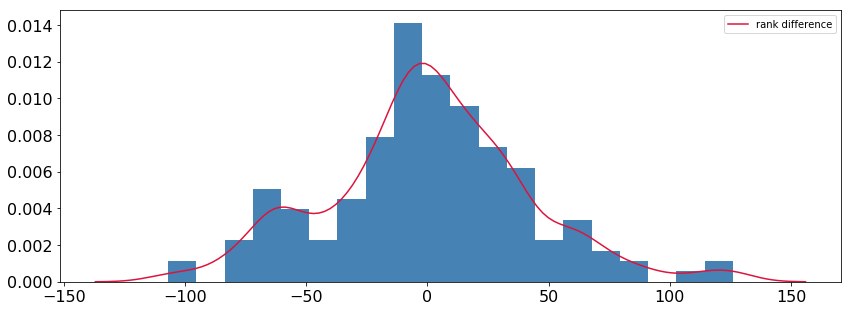

In [67]:
plt.hist(rdiff['rank difference'], normed=True, bins=20, color='steelblue')
sns.kdeplot(rdiff['rank difference'], bw=10, color='crimson')
plt.show()

# 5. Best University (aside from EPFL :))

# Propositions

- Look at the relative correlations of international student/stuff, not absolute (might be more representative).